# GE Discovery MI (Listmode Reconstruction; With Time of Flight)

This tutorial demonstrates how to reconstruct data listmode data in HDF5 data obtain from GE scanners. In this tutorial, we'll reconstruct using time-of-flight listmode. The data can be obtained from https://zenodo.org/records/8404015

In [1]:
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.io.PET import clinical


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


We first need to get the required PET geometry information dictionary from the scanner name. Currently, we only support `discovery_MI`, but feel free to make a commit to support other scanners (add to the `src/data/pet_scanner_info.txt` file)

In [2]:
scanner_name = 'discovery_MI'
info = clinical.get_detector_info(scanner_name)

Now we obtain the required data from the listmode files.

In [3]:
# Get listmode events
detector_ids = clinical.get_detector_ids_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/LIST0000.BLF', scanner_name)
# Get scatter/random correction term at each event
additive_term = clinical.get_additive_term_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5')
# Get multiplicative weights (attenuation/normalization) at each event
weights = clinical.get_weights_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5')
# Get ALL valid detector-pairs and corresponding multiplicative weights
detector_ids_sensitivity, weights_sensitivity = clinical.get_sensitivity_ids_and_weights_hdf5('/disk1/ge_discovery_tof_mi_pet/dmi_nema_lm/corrections.h5', scanner_name)

In [4]:
additive_term

tensor([0.0125, 0.0170, 0.0246,  ..., 0.0379, 0.0363, 0.0026])

In [5]:
from pytomography.io.PET import shared
scanner_LUT = shared.get_scanner_LUT(info)

First we'll get the required object space and projection space metadata.

* The `object_meta` specifies the size of each voxel, and the number of voxels in each direction
* The `proj_meta` specifies the list of all measured listmode events (`detector_ids`), the time-of-flight metadata, and the detector IDs / weights used for computing the sensitivity image.

In [6]:
# Define object space reconstruction matrix
object_meta = ObjectMeta(
    dr=(2.78,2.78,2.78), #mm
    shape=(192,192,71) #voxels
)
# Get time-of-flight metadata and define projection space metadata
tof_meta = clinical.get_tof_meta(scanner_name)
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=tof_meta,
    detector_ids_sensitivity=detector_ids_sensitivity,
    weights_sensitivity=weights_sensitivity
    )

Now we'll define the system matrix for the PET system. In this case we'll use 4.5mm PSF modeling.

In [7]:
psf_transform = GaussianFilter(4.5) # 2mm gaussian blurring
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    N_splits=8,
)

Now we'll define the likelihood function (`PoissonLogLikelihood` for PET systems). The additive term contains scatters/randoms and needs to be normalized by the `weights`.

In [8]:
likelihood = PoissonLogLikelihood(
    system_matrix,
    additive_term=additive_term/weights,
)

We can now reconstruct using a variety of reconstruction algorithms:

In [9]:
recon_algorithm = OSEM(likelihood)
recon_OSEM = recon_algorithm(n_iters=6, n_subsets=34)

In [10]:
# This is probably very similar to "Q.Clear" is ;)
prior = RelativeDifferencePrior(beta=25, gamma=2)
recon_algorithm = BSREM(likelihood, prior=prior)
recon_BSREM = recon_algorithm(n_iters=20, n_subsets=34)

Plot axial slice of reconstruction:

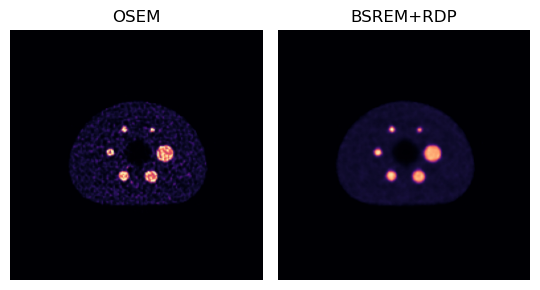

In [11]:
fig, ax = plt.subplots(1,2,figsize=(5.5,3))
plt.subplot(121)
plt.pcolormesh(recon_OSEM[:,:,20].T.cpu(), cmap='magma', shading='gouraud', vmax=0.5)
plt.axis('off')
plt.title('OSEM')
plt.subplot(122)
plt.pcolormesh(recon_BSREM[:,:,20].T.cpu(), cmap='magma', shading='gouraud', vmax=0.5)
plt.axis('off')
plt.title('BSREM+RDP')
fig.tight_layout()
plt.show()